# Intro

Here we use only **1** cell-type as perturbed, NOT all cell-types.
This is done when we generate the pseudobulks by sampling from either perturbed or non-perturbed cells within each sample.
This is denoted in the parameter `res_name`, it can be "all-kang", "mono-kang", "b-kang", "cd4Naive-kang", or "none-kang" and `idx_skip`.


This notebook takes the QC-ed the Kang et.al. data and generates pseudobulks.
The data was retreived using  the SeuratData package in R and then translated into an AnnData object to be read into python,
Notebook for SeuratData analysis of Kang data (names ifnb in SeuratData): https://satijalab.org/seurat/articles/integration_introduction.html
Seurat Disk was used for conversion between h5Seurat and AnnData: https://mojaveazure.github.io/seurat-disk/articles/convert-anndata.html

Kang data is originally from here: 
Kang, Hyun Min, et al. "Multiplexed droplet single-cell RNA-sequencing using natural genetic variation." Nature biotechnology 36.1 (2018): 89-94.


Data format requirements for single-cell data:
- processed data is not scaled
- cells are filtered such that low-quality cells are removed (for example: filter out cells with less than 200 genes and genes expressed in less than 3 cells, and > 5% MT reads)
- data is saved as an AnnData object and you have sample IDs, gene IDs, and cell-type labels
- In the end we will process the data such that we have the following features in the AnnData object that we will use to generate pseudobulks:
  - the observations have columns named: "sample_id", "stim", "isTraining"
  - sample_id: unique IDs for the samples
  - stim: is "STIM" or "CTRL", denotes if the sample is "stimulated" or "control"
  - isTraining: 'Train' or 'Test',  denotes if you can use the sample during training or not. In real use cases, all data will be "Train". To show validation of our experiment, we have access to "Test" data as well.
  


Pseudobulk features:
- we typically generate 1000 pseudobulks per sample with random proportions
- we generate 100 pseudobulks per sample, per cell type, where the cell-type of interest is >90% of the cell-type
- we typically sample 5000 cells for each pseudobulk





# Imports

In [1]:
import sys
sys.path.insert(1, '../../')
sys.path.insert(1, '../')
from buddi import buddi

from buddi.preprocessing import sc_preprocess


# general imports
import warnings
import numpy as np
import os
import pandas as pd
import scipy as sp
from scipy.sparse import coo_matrix
import collections
import scanpy as sc


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.manifold import TSNE
import sklearn as sk

# matplotlib settings for Jupyter notebooks only
%matplotlib inline

import pickle
import gzip
from pathlib import Path


2024-09-11 11:20:54.156926: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-11 11:20:54.157960: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-11 11:20:54.179801: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-11 11:20:54.180299: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-09-11 11:20:54.539556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT

In [2]:
from importlib import reload  # Python 3.4+
reload(sc_preprocess)

<module 'buddi.preprocessing.sc_preprocess' from '/home/natalie/projects/checkouts/buddi/buddi/preprocessing/sc_preprocess.py'>

# Parameters

In [3]:
# parameters

aug_data_path = f"{os.getcwd()}/../../data/single_cell_data/augmented_sciplex_data/"
cibersort_path = f"{os.getcwd()}/../../data/single_cell_data/cibersort_sciplex/"
data_path = f"{os.getcwd()}/../../data/single_cell_data/sciplex/"




#####################
### set the study ###
#####################

res_name = "all-sciplex"
in_name = "sciplex_processed"
processed_sc_file = f"{data_path}/{in_name}.h5ad"



# Load and Process data

### Read in data and metadata

In [4]:
# read in the data

adata = sc.read_h5ad(processed_sc_file)

adata.var_names_make_unique()  # this is unnecessary if using `var_names='gene_ids'` in `sc.read_10x_mtx`



In [5]:
adata.obs.product_name.value_counts()

Vehicle                             9550
Triamcinolone Acetonide             1325
Trichostatin A (TSA)                 906
Trametinib (GSK1120212)              861
Fedratinib (SAR302503, TG101348)     769
Tanespimycin (17-AAG)                506
Name: product_name, dtype: int64

In [6]:
# format metadata


def get_stim_id(in_str):
    out_str = "STIM"
    if in_str == "control":
        out_str = "CTRL"
           
    return(out_str)


adata.obs['CellType'] = adata.obs['cell_line'].tolist()
adata.obs['scpred_CellType'] = adata.obs['cell_line'].tolist()
adata.obs['sample_id'] = "samp1"
adata.obs['stim'] = [get_stim_id(str(x)) for x in adata.obs['perturbation'].tolist()]

""" 
adata.var['gene_ids'] = adata.var.gene_short_name.tolist()
adata.var.index = adata.var['gene_ids']

# remove genes that are duplicated
a = (adata.var['gene_ids'].value_counts() == 1)
a = a[a].keys().to_list()
unique_genes = np.unique(a)

adata = adata[:, adata.var['gene_ids'].isin(unique_genes)]

# make the common name the index
adata.var.index = adata.var['gene_ids']
 """

" \nadata.var['gene_ids'] = adata.var.gene_short_name.tolist()\nadata.var.index = adata.var['gene_ids']\n\n# remove genes that are duplicated\na = (adata.var['gene_ids'].value_counts() == 1)\na = a[a].keys().to_list()\nunique_genes = np.unique(a)\n\nadata = adata[:, adata.var['gene_ids'].isin(unique_genes)]\n\n# make the common name the index\nadata.var.index = adata.var['gene_ids']\n "

In [7]:
tab = adata.obs.groupby(['dose_value', 'product_name']).size()

tab.unstack()

product_name,"Fedratinib (SAR302503, TG101348)",Tanespimycin (17-AAG),Trametinib (GSK1120212),Triamcinolone Acetonide,Trichostatin A (TSA),Vehicle
dose_value,,,,,,
0.0,0,0,0,0,0,9550
1000.0,542,260,517,629,517,0
10000.0,227,246,344,696,389,0


In [8]:
adata.obs.columns

Index(['cell', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W',
       'top_to_second_best_ratio_W', 'top_oligo_W', 'hash_umis_P', 'pval_P',
       'qval_P', 'top_to_second_best_ratio_P', 'top_oligo_P', 'rt_well',
       'lig_well', 'pcr_well', 'pcr_plate', 'culture_plate', 'rt_plate',
       'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate',
       'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern',
       'dose_character', 'dose', 'treatment', 'pathway_level_1',
       'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose',
       'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score',
       'proliferation_index', 'UMAP_1', 'UMAP_2', 'Cluster',
       'louvain_component', 'batch', 'perturbation', 'cell_line', 'dose_value',
       'dose_unit', 'n_genes_by_counts', 'total_counts', 'total_counts_mt',
       'pct_counts_mt', 'n_genes', 'CellType', 'scpred_CellType', 'sample_id',
       'stim'],
      dtype='object')

In [9]:
adata.obs.rt_plate.value_counts()

2.0    3743
4.0    3736
3.0    3412
1.0    3026
Name: rt_plate, dtype: int64

### Preprocess

/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/seaborn/categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


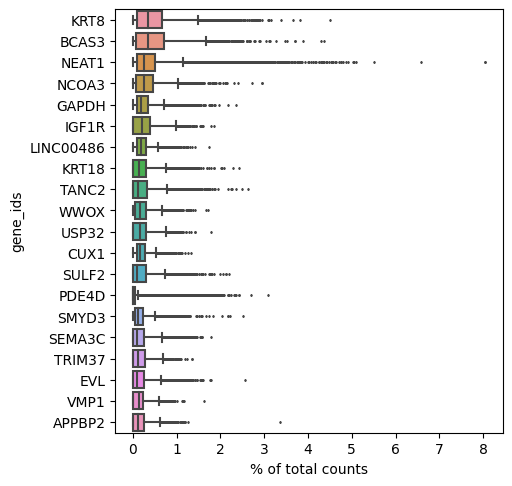

In [10]:
sc.pl.highest_expr_genes(adata, n_top=20, )


In [11]:
# check we don't have any weird cell types
adata.obs["scpred_CellType"].value_counts()


MCF7    7858
K562    3132
A549    2927
Name: scpred_CellType, dtype: int64

In [14]:
adata_ctrl = adata[np.where(adata.obs.stim == "CTRL")[0]]
adata_ctrl

View of AnnData object with n_obs × n_vars = 9550 × 8022
    obs: 'cell', 'Size_Factor', 'n.umi', 'hash_umis_W', 'pval_W', 'qval_W', 'top_to_second_best_ratio_W', 'top_oligo_W', 'hash_umis_P', 'pval_P', 'qval_P', 'top_to_second_best_ratio_P', 'top_oligo_P', 'rt_well', 'lig_well', 'pcr_well', 'pcr_plate', 'culture_plate', 'rt_plate', 'lig_plate', 'Combo', 'well_oligo', 'plate_oligo', 'replicate', 'drug_dose', 'catalog_number', 'vehicle', 'dose_pattern', 'dose_character', 'dose', 'treatment', 'pathway_level_1', 'pathway_level_2', 'product_name', 'target', 'pathway', 'product_dose', 'viability', 'num_genes_expressed', 'g1s_score', 'g2m_score', 'proliferation_index', 'UMAP_1', 'UMAP_2', 'Cluster', 'louvain_component', 'batch', 'perturbation', 'cell_line', 'dose_value', 'dose_unit', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'n_genes', 'CellType', 'scpred_CellType', 'sample_id', 'stim'
    var: 'id', 'gene_short_name', 'num_cells_expressed-0', 'num_cells_expres

In [18]:
# write out data for BP and cibersort
adata_ctrl = adata[np.where(adata.obs.stim == "CTRL")[0]]
dense_matrix = adata_ctrl.X.todense()

sc_profile_file = os.path.join(aug_data_path, f"{res_name}_sig.pkl")
sc_profile_path = Path(sc_profile_file)

dense_df = pd.DataFrame(dense_matrix, columns = adata_ctrl.var['gene_ids'])
dense_df.insert(loc=0, column='scpred_CellType', value=adata_ctrl.obs["scpred_CellType"].to_list())


pickle.dump( dense_df, open( sc_profile_path, "wb" ) )


In [13]:
dense_matrix.shape

(13917, 8022)

# Plot Data

/home/natalie/projects/checkouts/buddi_atac/.venv/lib/python3.10/site-packages/scanpy/plotting/_tools/scatterplots.py:378: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


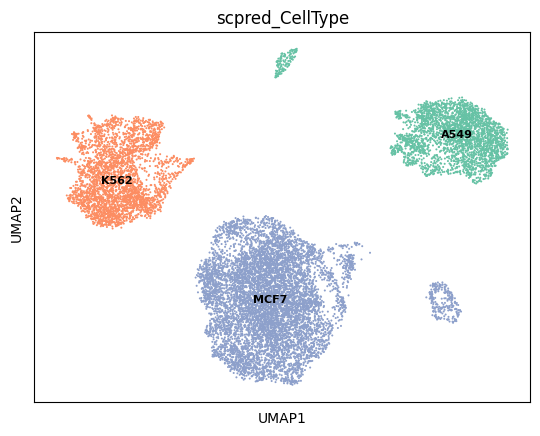

In [14]:
# valculate neighborhood graph
sc.pp.neighbors(adata)

# make umap
sc.tl.umap(adata)

# plot some markers of the RAW data
sc.pl.umap(adata, legend_loc='on data', color='scpred_CellType', legend_fontsize=8)


# Make Pseudobulks

In [15]:
adata.obs

,cell,Size_Factor,n.umi,hash_umis_W,pval_W,qval_W,top_to_second_best_ratio_W,top_oligo_W,hash_umis_P,pval_P,...,dose_unit,n_genes_by_counts,total_counts,total_counts_mt,pct_counts_mt,n_genes,CellType,scpred_CellType,sample_id,stim
cell,,,,,,,,,,,,,,,,,,,,,
A01_E09_RT_BC_119_Lig_BC_60,A01_E09_RT_BC_119_Lig_BC_60,0.950620,1279.0,125.0,0.0,0.0,56.936405,plate9_E4,143.0,0.0,...,nM,833,1271.0,246.0,19.354837,688,A549,A549,samp1,STIM
A01_E09_RT_BC_128_Lig_BC_154,A01_E09_RT_BC_128_Lig_BC_154,2.437126,3281.0,150.0,0.0,0.0,135.299254,plate7_H2,74.0,0.0,...,nM,1651,3243.0,836.0,25.778601,1378,A549,A549,samp1,STIM
A01_E09_RT_BC_177_Lig_BC_210,A01_E09_RT_BC_177_Lig_BC_210,1.893808,2549.0,213.0,0.0,0.0,101.923021,plate7_H2,116.0,0.0,...,nM,1424,2523.0,489.0,19.381689,1165,A549,A549,samp1,STIM
A01_E09_RT_BC_18_Lig_BC_104,A01_E09_RT_BC_18_Lig_BC_104,0.899336,1211.0,43.0,0.0,0.0,32.651210,plate4_C12,62.0,0.0,...,nM,759,1203.0,297.0,24.688280,612,A549,A549,samp1,CTRL
A01_E09_RT_BC_192_Lig_BC_248,A01_E09_RT_BC_192_Lig_BC_248,0.636224,856.0,44.0,0.0,0.0,36.899432,plate5_G5,35.0,0.0,...,nM,626,850.0,120.0,14.117648,522,A549,A549,samp1,CTRL
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
H12_F10_RT_BC_374_Lig_BC_125,H12_F10_RT_BC_374_Lig_BC_125,2.271733,5766.0,497.0,0.0,0.0,189.239060,plate5_G5,483.0,0.0,...,nM,2741,5730.0,944.0,16.474693,2247,MCF7,MCF7,samp1,CTRL
H12_F10_RT_BC_38_Lig_BC_157,H12_F10_RT_BC_38_Lig_BC_157,3.118592,7890.0,578.0,0.0,0.0,53.485211,plate9_E10,711.0,0.0,...,nM,3155,7818.0,1811.0,23.164494,2510,MCF7,MCF7,samp1,STIM
H12_F10_RT_BC_45_Lig_BC_273,H12_F10_RT_BC_45_Lig_BC_273,1.241427,3142.0,192.0,0.0,0.0,70.586633,plate9_E10,209.0,0.0,...,nM,1828,3115.0,196.0,6.292134,1456,MCF7,MCF7,samp1,STIM


In [16]:
adata.obs["scpred_CellType"].unique()

['A549', 'K562', 'MCF7']
Categories (3, object): ['A549', 'K562', 'MCF7']

In [17]:
# generate cell-type specific split
adata.obs["isTraining"] = "Train"
adata.obs["test_train_key"] = adata.obs["scpred_CellType"].astype(str) + adata.obs["perturbation"].astype(str)

# for each element in the key
# split by 50%
for curr_key in adata.obs["test_train_key"].unique():
  curr_idx = np.where(adata.obs["test_train_key"] == curr_key)[0]
  num_sample = np.floor(len(curr_idx)/2).astype(int)
  test_idx = np.random.choice(curr_idx, num_sample)
  adata.obs["isTraining"][test_idx] = "Test"

/tmp/ipykernel_16340/2374458522.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  adata.obs["isTraining"][test_idx] = "Test"


In [18]:
pd.set_option('display.max_rows', 160)

tab = adata.obs.groupby(['test_train_key', 'isTraining']).size()

tab.unstack()

isTraining,Test,Train
test_train_key,,
"A549Fedratinib (SAR302503, TG101348)",62,96
A549Tanespimycin (17-AAG),61,93
A549Trametinib (GSK1120212),53,82
A549Triamcinolone Acetonide,85,140
A549Trichostatin A (TSA),92,151
A549control,781,1231
"K562Fedratinib (SAR302503, TG101348)",42,66
K562Tanespimycin (17-AAG),42,71
K562Trametinib (GSK1120212),67,107


In [19]:
tab = adata.obs.groupby(['isTraining', 'sample_id']).size()

tab.unstack()

sample_id,samp1
isTraining,
Test,5470
Train,8447


In [20]:
tab = adata.obs.groupby(['isTraining', 'stim']).size()

tab.unstack()

stim,CTRL,STIM
isTraining,,
Test,3766,1704
Train,5784,2663


### Generate proportions matrix + pseudobulk

In [21]:
stim_idx = np.where(np.logical_and(adata.obs.stim == "STIM", adata.obs.isTraining == "Train"))[0]
tab = adata.obs.iloc[stim_idx].groupby(['perturbation', 'scpred_CellType']).size()
tab.unstack()

scpred_CellType,A549,K562,MCF7
perturbation,,,
"Fedratinib (SAR302503, TG101348)",96,66,300
Tanespimycin (17-AAG),93,71,148
Trametinib (GSK1120212),82,107,331
Triamcinolone Acetonide,140,231,438
Trichostatin A (TSA),151,78,331
control,0,0,0


In [22]:
adata.obs["perturbation"].unique()

['Trametinib (GSK1120212)', 'Triamcinolone Acetonide', 'control', 'Trichostatin A (TSA)', 'Tanespimycin (17-AAG)', 'Fedratinib (SAR302503, TG101348)']
Categories (6, object): ['Fedratinib (SAR302503, TG101348)', 'Tanespimycin (17-AAG)', 'Trametinib (GSK1120212)', 'Triamcinolone Acetonide', 'Trichostatin A (TSA)', 'control']

In [23]:
adata.obs.scpred_CellType.unique()

['A549', 'K562', 'MCF7']
Categories (3, object): ['A549', 'K562', 'MCF7']

In [23]:
# write out the gene ids
gene_pass = adata.var['gene_ids']
gene_out_file = os.path.join(aug_data_path, f"{res_name}_genes.pkl")
gene_out_path = Path(gene_out_file)
pickle.dump( gene_pass, open( gene_out_path, "wb" ) )

# metadata
stim_order = ['STIM', 'CTRL']
train_order = ['Train', 'Test']
drug_order = ['control', 'Fedratinib (SAR302503, TG101348)', 'Tanespimycin (17-AAG)', 'Trichostatin A (TSA)', 'Triamcinolone Acetonide', 'Trametinib (GSK1120212)']

curr_samp = "samp1"

# now generate all the proportions
total_meta_df = pd.DataFrame(columns = ["sample_id", "stim", "isTraining", "perturbation"])

# no cell noise 
len_vector = adata.obs["scpred_CellType"].unique().shape[0]
cell_noise = [np.random.lognormal(0, 0, adata.var['gene_ids'].shape[0]) for i in range(len_vector)]

# cell type order
cell_order = adata.obs.scpred_CellType.unique()

# simulate different number of cells
num_cells = 5000
idx = 0
for curr_drug in drug_order:
  if curr_drug == "control":
    continue

  drug_idx = np.where((adata.obs["perturbation"] == curr_drug) | (adata.obs["perturbation"] == "control"))

  adata_drug = adata[drug_idx]

  for curr_cell_type in adata_drug.obs["scpred_CellType"].unique():

    # in order to make a single cell typy perturbed
    # we will only take the STIM of one type and all other cell-types in "stim" will be from CTRL
    idx_skip = np.where(adata_drug.obs["scpred_CellType"].unique() == curr_cell_type)[0]
    idx_keep_cell = np.where(adata_drug.obs["scpred_CellType"].unique() != curr_cell_type)[0]
    keep_cell_types = adata_drug.obs["scpred_CellType"].unique()[idx_keep_cell]
    stim_cell_type = adata_drug.obs["scpred_CellType"].unique()[idx_skip] # cd14 mono OR b OR cd4NaiveT

    stim_fake = np.logical_and(adata_drug.obs.scpred_CellType.isin(keep_cell_types), adata_drug.obs.stim == "CTRL" )
    stim_real = np.logical_and(adata_drug.obs.scpred_CellType.isin(stim_cell_type), adata_drug.obs.stim == "STIM" )
    stim_ternary = np.logical_or(stim_fake, stim_real)

    adata_drug.obs[stim_ternary].scpred_CellType.value_counts()

    # for all other samples
    for curr_stim in stim_order:

      sample_noise = None ## when using training data -- this generates the sample_noise
      for curr_train in train_order:

        print(f"{res_name} {curr_cell_type} {curr_drug} {curr_stim} {curr_train}")

        ########################################################
        ### GET CELLS TO SAMPLE FROM
        ########################################################
        # subset adata_drug to get the correct cells to sample from
        subsamp_subset_idx = adata_drug.obs.isTraining == curr_train
        if curr_stim == "STIM":
          subsamp_subset_idx = np.logical_and(subsamp_subset_idx, stim_ternary)
        else:
          subsamp_subset_idx = np.logical_and(subsamp_subset_idx, adata_drug.obs.stim == "CTRL")
        
        sampling_adata_drug = adata_drug[subsamp_subset_idx]



        ########################################################
        ### MAKE PSEUDOBULKS
        ########################################################

        ## if we are training and stim, we need to make sure we only have bulk
        if curr_stim == "STIM" and curr_train == "Train":
          # now get the pseudobulks
          prop_df, pseudobulks_df, test_prop_df, test_pseudobulks_df = sc_preprocess.make_prop_and_sum(sampling_adata_drug, 
                                                                                  num_samples=500, 
                                                                                  num_cells=num_cells,
                                                                                  use_true_prop=False,
                                                                                  cell_noise=cell_noise,
                                                                                  useSampleNoise=False)

          # number of random pseudobulks
          num_rand_pseudo = pseudobulks_df.shape[0] 
          cell_prop_type = ["random"]*num_rand_pseudo
          num_samps = pseudobulks_df.shape[0] 
          samp_type = ["bulk"]*num_samps
        
        else:
          # "bulk" pseudobulks
          bulk_prop_df, bulk_pseudobulks_df, bulk_test_prop_df, bulk_test_pseudobulks_df = sc_preprocess.make_prop_and_sum(sampling_adata_drug, 
                                                                                  num_samples=500, 
                                                                                  num_cells=num_cells,
                                                                                  use_true_prop=False,
                                                                                  cell_noise=cell_noise,
                                                                                  useSampleNoise=False)
          # number of random "bulk" pseudobulks
          num_rand_pseudo = bulk_pseudobulks_df.shape[0] 
          bulk_cell_prop_type = ["random"]*num_rand_pseudo
          num_samps = bulk_pseudobulks_df.shape[0] 
          bulk_samp_type = ["bulk"]*num_samps

          # "sc" pseudobulks
          sc_prop_df, sc_pseudobulks_df, sc_test_prop_df, sc_test_pseudobulks_df = sc_preprocess.make_prop_and_sum(sampling_adata_drug, 
                                                                                  num_samples=500, 
                                                                                  num_cells=num_cells,
                                                                                  use_true_prop=False,
                                                                                  cell_noise=cell_noise,
                                                                                  useSampleNoise=False)
          # number of random "sc_ref" pseudobulks
          num_rand_pseudo = sc_pseudobulks_df.shape[0] 
          sc_cell_prop_type = ["random"]*num_rand_pseudo
          num_samps = sc_pseudobulks_df.shape[0] 
          sc_samp_type = ["sc_ref"]*num_samps

          # get the single cell type proportions
          print("get_single_celltype_prop_matrix")
          ct_prop_df = sc_preprocess.get_single_celltype_prop_matrix(num_samp=500, # 100
                                                                      cell_order=cell_order)

          # now get the cell-type specific pseudobulks
          print("use_prop_make_sum")
          prop_df_sc, pseudobulks_df_sc, _ = sc_preprocess.use_prop_make_sum(sampling_adata_drug,  
                                                                              num_cells=num_cells, 
                                                                              props_vec=ct_prop_df, 
                                                                              cell_noise=cell_noise,
                                                                              sample_noise=None,
                                                                              useSampleNoise=False)

          # number of ct_specific pseudobulks
          num_ct_pseudo = pseudobulks_df_sc.shape[0] 
          ct_cell_prop_type = ["cell_type_specific"]*num_ct_pseudo
          num_samps = pseudobulks_df_sc.shape[0] 
          ct_samp_type = ["sc_ref"]*num_samps


          # put them together
          print("concat")        
          prop_df = pd.concat([bulk_prop_df, sc_prop_df, prop_df_sc])
          pseudobulks_df = pd.concat([bulk_pseudobulks_df, sc_pseudobulks_df, pseudobulks_df_sc])

          cell_prop_type = bulk_cell_prop_type+sc_cell_prop_type+ct_cell_prop_type
          samp_type = bulk_samp_type+sc_samp_type+ct_samp_type



        # make the proportions instead of cell counts
        prop_df = prop_df.div(prop_df.sum(axis=1), axis=0)


        # make the metadata
        num_samps = pseudobulks_df.shape[0] 
        metadata_df = pd.DataFrame(data = {"sample_id":[curr_samp]*num_samps, 
                                          "stim":[curr_stim]*num_samps,
                                          "isTraining":[curr_train]*num_samps,
                                          "cell_prop_type":cell_prop_type,
                                          "samp_type":samp_type,
                                          "perturbation":curr_drug,
                                          "cell_type_perturbed":curr_cell_type})
        
        pseudobulk_file = os.path.join(aug_data_path, f"{res_name}_{curr_drug}_{curr_cell_type}_{curr_stim}_{curr_train}_pseudo_splits.pkl")
        prop_file = os.path.join(aug_data_path, f"{res_name}_{curr_drug}_{curr_cell_type}_{curr_stim}_{curr_train}_prop_splits.pkl")
        meta_file = os.path.join(aug_data_path, f"{res_name}_{curr_drug}_{curr_cell_type}_{curr_stim}_{curr_train}_meta_splits.pkl")

        print("write")        
        pseudobulk_path = Path(pseudobulk_file)
        prop_path = Path(prop_file)
        meta_path = Path(meta_file)

        pickle.dump( prop_df, open( prop_path, "wb" ) )
        pickle.dump( pseudobulks_df, open( pseudobulk_path, "wb" ) )
        pickle.dump( metadata_df, open( meta_path, "wb" ) )





all-sciplex A549 Fedratinib (SAR302503, TG101348) STIM Train
0


100
200
300
400
500
write
all-sciplex A549 Fedratinib (SAR302503, TG101348) STIM Test
0
100
200
300
400
500
0
100
200
300
400
500
get_single_celltype_prop_matrix
use_prop_make_sum
0
100
200
300
400
500
600
700
800
900
1000
